# Quantum Kernel for Gaussian Process Regressor
This tutorial demonstrates the use of a **quantum kernel** within a **Gaussian Process (GP)** for regression. Designed for clarity, it addresses a classic regression problem: $$f(x) = x \sin(x)$$ <br>
Despite the problem's simplicity, the code is structured to accommodate more complex, high-dimensional problems, allowing for easy modification for other tasks. <br>

### Objectives

The primary goals of this tutorial are to:

- Introduce the application of a **Quantum Kernel** in a **Gaussian Process (QGP)**.
- Serve as a foundational step for developing a **Bayesian Optimisation** algorithm that utilizes a surrogate model based on QGPs.

### Tutorial Steps

This tutorial will guide you through the following steps:

1. **Prepare the Dataset**: Load and pre-process the data required for the regression task.
   
2. **Define the Quantum Feature Map**: Specify the quantum circuit to encode classical data into a quantum state.
   
3. **Define the Quantum Kernel**: Construct the kernel matrix based on the fidelity between quantum states generated by the feature map.
   
4. **Train the QGP Model**: Train the Gaussian Process model using the quantum kernel.
   
5. **Make Predictions with the QGP**: Use the trained QGP model to predict output values for new input data.
   
6. **Compare with a Classical GP**: Evaluate the performance of the QGP model against a traditional Gaussian Process model with a classical kernel.


In [1]:
# Import packages
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, RBF

from scipy.optimize import minimize


## 1. Prepare the Dataset

We define a simple regression problem: 

$$
f(x) = x \sin(x)
$$

The dataset will be generated and split into training and testing sets.

In [2]:
# Generate dataset
total_samples = 30
train_size = int(0.7 * total_samples) #70% for training
#test_size = int(0.3 * total_samples)

X = np.linspace(0, 10, total_samples) 
y = X* np.sin(X)

indices = np.arange(len(X)) # Random permutation of indices
np.random.shuffle(indices)
shuffled_data = X[indices]

X0_train = X[np.sort(indices[:train_size])]
X0_test = X#[np.sort(indices[train_size:train_size + test_size])]

X_train = np.transpose(np.vstack((X0_train, X0_train*np.sin(X0_train))))
y_train = X0_train *np.sin(X0_train) #x*sin(x)

X_test = np.transpose(np.vstack((X0_test, X0_test*np.sin(X0_test))))
y_test = X0_test *np.sin(X0_test) #x*sin(x)

#Normalize the features
scaler_features = MinMaxScaler()
X_train_normalized = scaler_features.fit_transform(X_train)
X_test_normalized = scaler_features.transform(X_test)



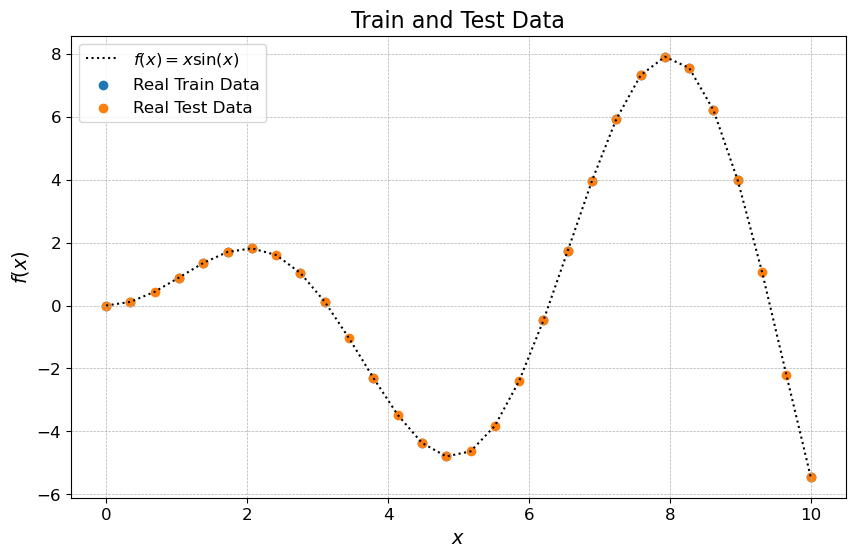

In [3]:
#We visualize our function and dataset
plt.figure(figsize=(10, 6))
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted", c='k')
plt.scatter(X0_train, y_train, label="Real Train Data", c='C0')
plt.scatter(X0_test, y_test, label='Real Test Data', c='C1')
plt.title('Train and Test Data', fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$f(x)$", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 2. Feature Map

The feature map is a crucial step in a quantum algorithm, as the choice of circuit directly impacts the model's performance. Given our target function $ f(x) = x \sin(x)$.  <br>

we can encode x into one qubit and f(x) into a second qubit. This approach aligns our quantum representation with the underlying function, potentially enhancing the model's expressiveness and efficiency.

In [4]:
def trainable_feature_map(num_qubits, num_layers=1):
    """Creates a trainable quantum feature map encoding x and x*sin(x)."""
    data = ParameterVector('x', length=num_qubits)  # Input data parameters
    theta = ParameterVector('θ', length=num_qubits * num_layers * 2)  # Trainable parameters

    qc = QuantumCircuit(num_qubits)
    
    qc.rx(data[0], 0)
    qc.ry(data[1], 1) 

    param_idx = 0
    for l in range(num_layers):
        for i in range(num_qubits):
            qc.h(i) # Hadamard
            qc.rz(theta[param_idx], i)  # Z-gate
            param_idx += 1
            qc.rx(theta[param_idx], i)  # X-gate
            param_idx += 1
        qc.cx(0, 1)  # Introduce entanglement
    
    return qc, theta





## 3. Define the Quantum Kernel

The Gaussian Process requires a kernel. In this case, we will use a quantum kernel based on the fidelity between quantum states generated by our feature map. This kernel will enable us to capture the relationships between data points in the quantum feature space.


In [5]:

def create_fidelity_kernel(params, feature_map, trainable_params):
    updated_feature_map = feature_map.assign_parameters({trainable_params[i]: params[i] for i in range(len(params))})
 
    sampler = StatevectorSampler()
    fidelity = ComputeUncompute(sampler=sampler)
    return FidelityQuantumKernel(fidelity=fidelity, feature_map=updated_feature_map)



class QuantumKernelWrapper(Kernel):
    """Wraps FidelityQuantumKernel for compatibility with sklearn GPR."""

    def __init__(self, quantum_kernel):
        self.quantum_kernel = quantum_kernel

    def __call__(self, X, Y=None, eval_gradient=False):
        """Computes the kernel matrix for input data X and Y."""
        if Y is None:
            Y = X  # Kernel is symmetric
        
        # Compute quantum kernel matrix
        kernel_matrix = self.quantum_kernel.evaluate(X, Y)
        
        if eval_gradient:
            raise NotImplementedError("Gradient computation is not supported for quantum kernels.")
        
        return kernel_matrix

    def diag(self, X):
        """Returns diagonal elements of the kernel matrix (self-similarity)."""
        return np.ones(X.shape[0])

    def is_stationary(self):
        """Quantum kernels are generally not stationary."""
        return False


## 4. Train the Quantum Gaussian Process Model

Now we are ready to train our model. This involves optimising the kernel (i.e., the feature map) and other GP parameters.

To optimise these parameters, we will use the `minimize` function from Scikit-Learn. The objective function is defined as the **log marginal likelihood**.

Once an optimal kernel is found, we retrain the GP with the optimised parameters. This ensures our model is well-tuned for the regression task.


In [6]:
parameter_history = []
# Optimization objective: negative log marginal likelihood
def objective_function(params, X_train, y_train, feature_map, trainable_params):
    """Compute negative log marginal likelihood using current parameters."""

    global parameter_history
    parameter_history.append(params.copy())  # Store the current parameters

    # Update quantum kernel with new parameters    
    fidelity_kernel = create_fidelity_kernel(params, feature_map, trainable_params)  # Create new kernel

    # Wrap it for sklearn
    quantum_kernel_wrapper = QuantumKernelWrapper(fidelity_kernel)
    
    # Fit GPR model
    qgp = GaussianProcessRegressor(kernel=quantum_kernel_wrapper, alpha=0.01)
    qgp.fit(X_train, y_train)
    
    # Compute the log marginal likelihood (LML)
    lml = qgp.log_marginal_likelihood()
    
    return -lml  # Minimize negative LML

In [7]:
# Adjust as needed
num_qubits = 2  
num_layers = 3
feature_map, trainable_params = trainable_feature_map(num_qubits, num_layers)

# Initialize parameters randomly
initial_params = np.random.rand(len(trainable_params))
bounds = [(0, 2 * np.pi)] * len(trainable_params)  #bounds

# Optimize the parameters
result = minimize(
    objective_function,
    initial_params,
    args=(X_train_normalized, y_train, feature_map, trainable_params),
    method="L-BFGS-B",
      bounds=bounds
)

# Get optimized parameters
optimized_params = result.x
print("Optimized Parameters:", optimized_params)

Optimized Parameters: [0.45935876 0.62790647 0.36234396 0.31933612 0.35918224 0.20164501
 0.44412102 0.35013202 0.01781201 0.05018079 0.40983922 0.1436949 ]


In [8]:
# Assign trained parameters to quantum kernel
trained_fidelity_kernel = create_fidelity_kernel(optimized_params, feature_map, trainable_params)

# Wrap and fit the GPR model
quantum_kernel_wrapper = QuantumKernelWrapper(trained_fidelity_kernel)
qgp = GaussianProcessRegressor(kernel=quantum_kernel_wrapper, alpha=0.01)
qgp.fit(X_train_normalized, y_train)


GaussianProcessRegressor(alpha=0.01, kernel=QuantumKernelWrapper())

## 5. Make Predictions with the Quantum Gaussian Process

With our model trained, we can now make predictions and visualize the results. This involves using the quantum Gaussian Process to generate predictions for new input data and plotting these predictions against the true function values.


In [9]:

# Make predictions
y_pred_train, y_std_train = qgp.predict(X_train_normalized, return_std=True)
y_pred_test, y_std_test = qgp.predict(X_test_normalized, return_std=True)


# Calculate metrics
metrics_qgp = {'rmse_train': root_mean_squared_error(y_pred_train, y_train),
                    'rmse_test': root_mean_squared_error(y_pred_test, y_test),
                    'mape_train': mean_absolute_percentage_error(y_pred_train, y_train),
                    'mape_test': mean_absolute_percentage_error(y_pred_test, y_test),
                    }

print('Results Quantum Gaussian Process:  ')
print(f'RMSE train: { metrics_qgp['rmse_train']:.4f}')
print(f'RMSE test: {  metrics_qgp['rmse_test']:.4f}')
print(f'MAPE train: { metrics_qgp['mape_train']:.4f}')
print(f'MAPE test: {  metrics_qgp['mape_test']:.4f}')

/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:477: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


Results Quantum Gaussian Process:  
RMSE train: 0.8871
RMSE test: 0.9228
MAPE train: 0.3462
MAPE test: 0.8303


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:477: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


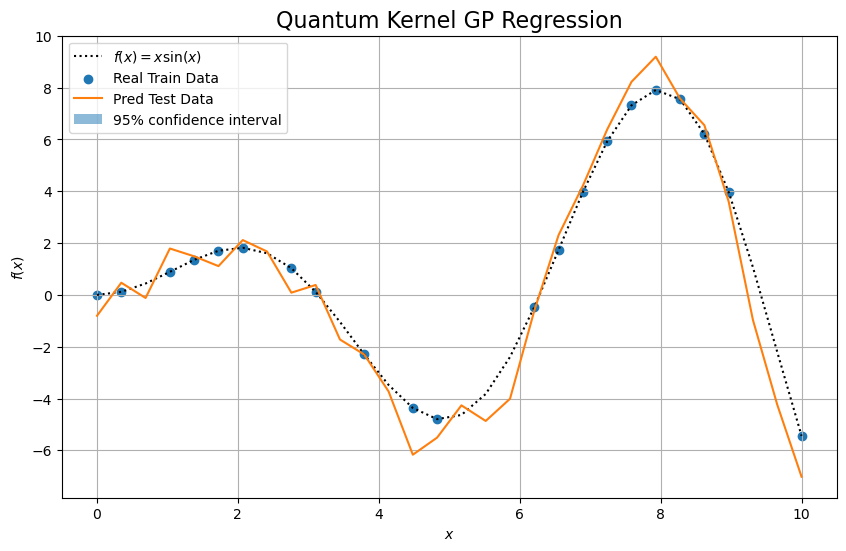

In [10]:

plt.figure(figsize=(10, 6))
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted", c='k')
plt.scatter(X0_train, y_train, label="Real Train Data", c='C0')
#plt.scatter(X0_test, y_test, label="Real Test Data", c='C1', alpha=0.7)
#plt.plot(X0_train, y_pred_train, label='Pred Train Data', c='C0')
plt.plot(X0_test, y_pred_test, label='Pred Test Data', c='C1')
plt.fill_between(
    X0_test,
    y_pred_test - 1.96 * y_std_test,
    y_pred_test + 1.96 * y_std_test,
    alpha=0.5,
    label=r"95% confidence interval",
    )

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title('Quantum Kernel GP Regression', fontsize=16)
plt.grid(True)
plt.show()


## 6. Classical Gaussian Process 

To evaluate our algorithm, we will compare its performance with a **classical Gaussian Process**, using a standard kernel like the RBF kernel as a benchmark.

In [11]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
cgp = GaussianProcessRegressor(kernel=kernel)
cgp.fit(X_train_normalized, y_train)

# Make predictions
y_pred_train, y_std_train = cgp.predict(X_train_normalized, return_std=True)
y_pred_test, y_std_test = cgp.predict(X_test_normalized, return_std=True)


metrics_cgp = {'rmse_train': root_mean_squared_error(y_pred_train, y_train),
                    'rmse_test': root_mean_squared_error(y_pred_test, y_test),
                    'mape_train': mean_absolute_percentage_error(y_pred_train, y_train),
                    'mape_test': mean_absolute_percentage_error(y_pred_test, y_test),
                    }

print('Results Classical Gaussian Process:  ')
print(f'RMSE train: { metrics_cgp['rmse_train']:.4f}')
print(f'RMSE test: {  metrics_cgp['rmse_test']:.4f}')
print(f'MAPE train: { metrics_cgp['mape_train']:.4f}')
print(f'MAPE test: {  metrics_cgp['mape_test']:.4f}')


Results Classical Gaussian Process:  
RMSE train: 0.0000
RMSE test: 0.0000
MAPE train: 0.0476
MAPE test: 0.0333


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:477: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:477: UserWarning: Predicted variances smaller 

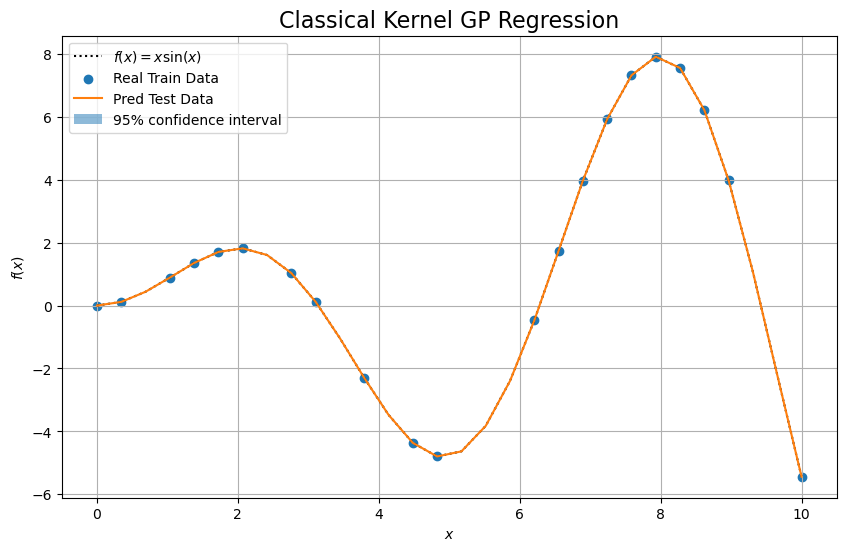

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted", c='k')
plt.scatter(X0_train, y_train, label="Real Train Data", c='C0')
#plt.scatter(X0_test, y_test, label="Real Test Data", c='C1', alpha=0.7)
#plt.plot(X0_train, y_pred_train, label='Pred Train Data', c='C0')
plt.plot(X0_test, y_pred_test, label='Pred Test Data', c='C1')
plt.fill_between(
    X0_test,
    y_pred_test - 1.96 * y_std_test,
    y_pred_test + 1.96 * y_std_test,
    alpha=0.5,
    label=r"95% confidence interval",
    )

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title('Classical Kernel GP Regression', fontsize=16)
plt.grid(True)
plt.show()
